## 1、导入库

In [309]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
import matplotlib.cm as cm
import sklearn 
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder   # 编码转换
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier     # 随机森林
from sklearn.svm import SVC,LinearSVC                   # 支持向量机
from sklearn.linear_model import LogisticRegression     # 逻辑回归
from sklearn.neighbors import KNeighborsClassifier      # KNN
from sklearn.naive_bayes import GaussianNB              # 朴素贝叶斯
from sklearn.tree import DecisionTreeClassifier         # 决策树
from lightgbm import LGBMClassifier                     
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import classification_report,precision_score,recall_score,f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.ensemble import VotingClassifier

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore')

## 2、查看数据

In [310]:
data=pd.read_csv('./data/titanic/train.csv')

In [290]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [291]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [292]:
data.shape

(891, 12)

In [293]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


## 3、数据清洗

In [294]:
pd.isnull(data).sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

#### 可以看到，Cabin缺失的值太多了，考虑整列去掉，age缺失的行数去掉
#### 同时将乘客id,name等无关信息去掉

In [311]:
data2=data.copy()
data2=data2.drop(['PassengerId','Name','Ticket','Cabin'],axis=1)
data2.dropna(inplace=True)

In [296]:
data2.shape

(712, 8)

In [297]:
data2.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


#### 将性别替换成数字类型

In [312]:
data2['Sex'].replace(to_replace='male',value=1,inplace=True)
data2['Sex'].replace(to_replace='female',value=0,inplace=True)

## 4、数据可视化

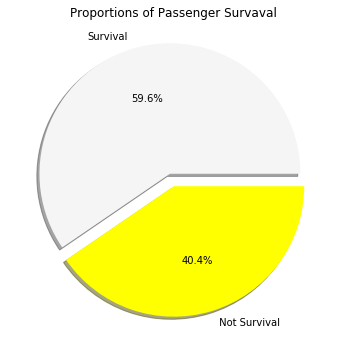

In [36]:
%matplotlib inline
survival_value=data2['Survived'].value_counts()
#labels=telcom["Churn"].value_counts().index
labels=['Survival',' Not Survival']

rcParams["figure.figsize"]=6,6
# explode是每一块距离中心的距离
# autopct控制饼图内百分比设置,可以使用format字符串或者format function '%1.1f'指小数点前后位数(没有用空格补齐)
plt.pie(survival_value,labels=labels,colors=["whitesmoke","yellow"], explode=(0.1,0),autopct='%1.1f%%', shadow=True)
plt.title("Proportions of Passenger Survaval")
plt.show()

### 性别，仓位等对生存率的影响

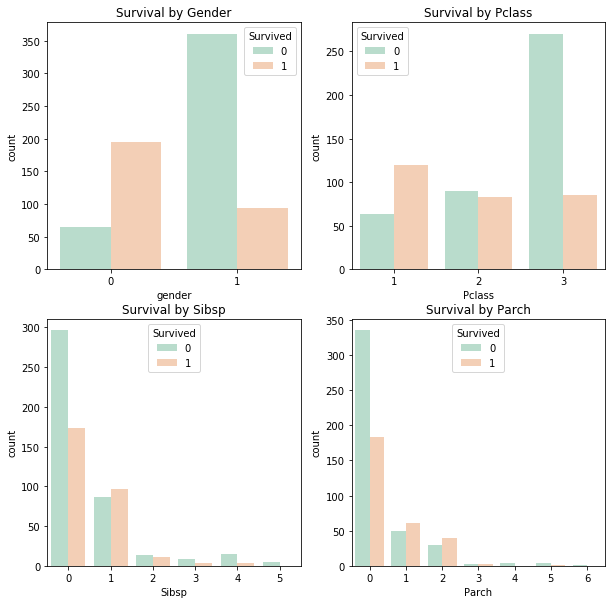

In [38]:
f, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

plt.subplot(2,2,1)
sns.countplot(x="Sex",hue="Survived",data=data2,palette="Pastel2") # palette参数表示设置颜色，这里设置为主题色Pastel2
plt.xlabel("gender")
plt.title("Survival by Gender")

plt.subplot(2,2,2)
sns.countplot(x="Pclass",hue="Survived",data=data2,palette="Pastel2")
plt.xlabel("Pclass")
plt.title("Survival by Pclass")

plt.subplot(2,2,3)
sns.countplot(x="SibSp",hue="Survived",data=data2,palette="Pastel2")
plt.xlabel("Sibsp")
plt.title("Survival by Sibsp")

plt.subplot(2,2,4)
sns.countplot(x="Parch",hue="Survived",data=data2,palette="Pastel2")
plt.xlabel("Parch")
plt.title("Survival by Parch")
plt.show()


In [39]:
corr=data2.corr()
corr

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
Survived,1.000000,-0.356462,-0.536762,-0.082446,-0.015523,0.095265,0.266100
Pclass,-0.356462,1.000000,0.150826,-0.365902,0.065187,0.023666,-0.552893
Sex,-0.536762,0.150826,1.000000,0.099037,-0.106296,-0.249543,-0.182457
Age,-0.082446,-0.365902,0.099037,1.000000,-0.307351,-0.187896,0.093143
SibSp,-0.015523,0.065187,-0.106296,-0.307351,1.000000,0.383338,0.139860
Parch,0.095265,0.023666,-0.249543,-0.187896,0.383338,1.000000,0.206624
Fare,0.266100,-0.552893,-0.182457,0.093143,0.139860,0.206624,1.000000


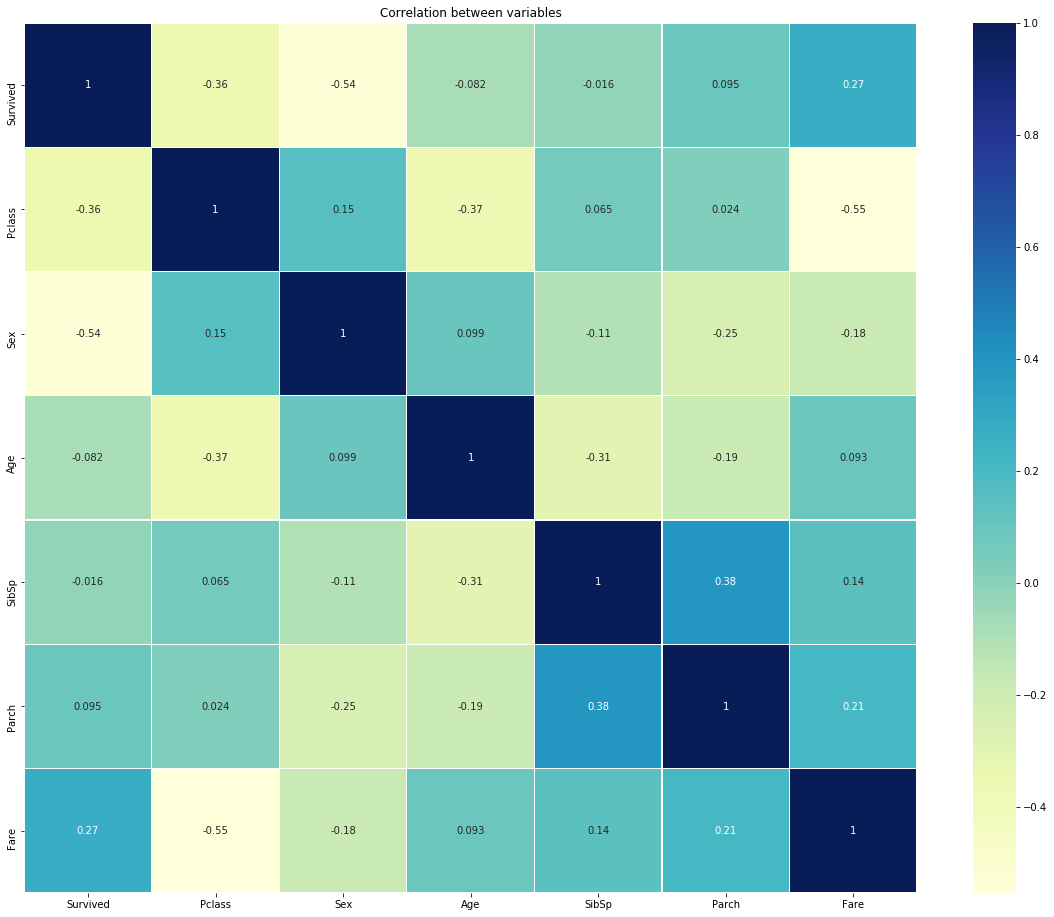

In [40]:
# 使用热地图显示相关系数
'''
heatmap    使用热地图展示系数矩阵情况
linewidths 热力图矩阵之间的间隔大小
annot      设定是否显示每个色块的系数值
'''
plt.figure(figsize=(20,16))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, linewidths=0.2, cmap="YlGnBu",annot=True)
plt.title("Correlation between variables")
plt.show()

### one-hot编码

In [341]:
data3=pd.get_dummies(data2)

In [342]:
data3['Age_bin']=pd.cut(data3['Age'].astype(int),5)
#data3['Fare_bin']=pd.cut(data3['Fare'].astype(int),10)
label=LabelEncoder()
data3['AgeBin_code']=label.fit_transform(data3['Age_bin'])
#data3['FareBin_code']=label.fit_transform(data3['Fare_bin'])
data3=data3.drop(['Age','Age_bin'],axis=1)
#data3=data3.drop(['Fare','Fare_bin'],axis=1)

In [334]:
data3.head()

,Survived,Pclass,Sex,SibSp,Parch,Embarked_C,Embarked_Q,Embarked_S,AgeBin_code,FareBin_code
0,0,3,1,1,0,0,0,1,1,0
1,1,1,0,1,0,1,0,0,2,1
2,1,3,0,0,0,0,0,1,1,0
3,1,1,0,1,0,0,0,1,2,1
4,0,3,1,0,0,0,0,1,2,0


### 查看各变量与是否获救的相关度关系

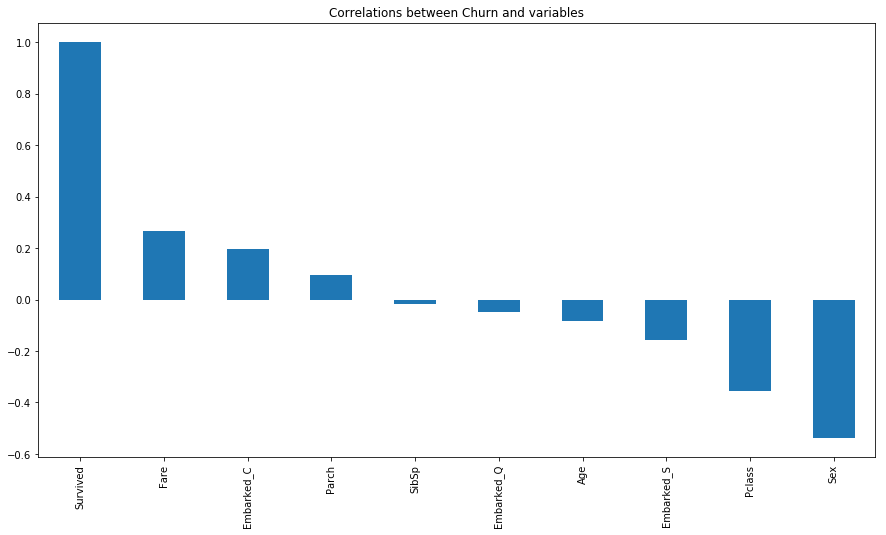

In [46]:
plt.figure(figsize=(15,8))
data3.corr()['Survived'].sort_values(ascending = False).plot(kind='bar')
plt.title("Correlations between Churn and variables")
plt.show()

### sibsp与是否获救的相关性是最低的，可以考虑删除，但是因为列数太少了，所以还是先留着

### 对船票数值进行取均值归一化

In [343]:
"""
标准化数据，保证每个维度的特征数据方差为1，均值为0，使得预测结果不会被某些维度过大的特征值而主导。
就是（旧值-均值）/ 标准差
"""
scaler = StandardScaler(copy=False)
# fit_transform()的作用就是先拟合数据，然后转化它将其转化为标准形式
data3['Fare']=scaler.fit_transform(data3[['Fare']])

In [254]:
data3.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,AgeBin_code
0,0,3,1,1,0,-0.516380,0,0,1,1
1,1,1,0,1,0,0.694046,1,0,0,2
2,1,3,0,0,0,-0.503620,0,0,1,1
3,1,1,0,1,0,0.350326,0,0,1,2
4,0,3,1,0,0,-0.501257,0,0,1,2


## 5、构建模型

In [344]:
"""
我们需要将数据集拆分为训练集和测试集以进行验证。
由于我们所拥有的数据集是不平衡的，所以最好使用分层交叉验证来确保训练集和测试集都包含每个类样本的保留人数。
交叉验证函数StratifiedShuffleSplit，功能是从样本数据中随机按比例选取训练数据（train）和测试数据（test）
参数 n_splits是将训练数据分成train/test对的组数，可根据需要进行设置，默认为10
参数test_size和train_size是用来设置train/test对中train和test所占的比例
参数 random_state控制是将样本随机打乱
"""

y=data3["Survived"].values
X=data3.iloc[:,1:]
sss=StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
print(sss)
print("训练数据和测试数据被分成的组数：",sss.get_n_splits(X,y))

StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=0.2,
            train_size=None)
训练数据和测试数据被分成的组数： 5


In [345]:
# 建立训练数据和测试数据
for train_index, test_index in sss.split(X, y):
    print("train:", train_index, "test:", test_index)
    X_train,X_test=X.iloc[train_index], X.iloc[test_index]
    y_train,y_test=y[train_index], y[test_index]

train: [506 127 149 434 567 670 268 165 326 120 551  87 350 653 633 595 558 317
 192 599 449  63 479 557 710   0 499 246 302 612 676 339 321 531 394 131
  91 556 280 591 521 117 538 564 408 132  92 421 340  36 207 525 201 128
 501 386 299 696 220 705 377 700 336 433 622 598 100  40 181 470 125 236
  51 418 245 249 188 694 512 166 568 380 345 709 474 334 206 655 337 369
  69 489 244 362 382 142 695 140 240  83 168 410 638 363 650 495 594  56
 263 367 216  79 482 243 135 529  39  86 121 284 217 429  15 500 348  80
  99 400 218 533 307 534 186 211  89 502 440 619 605 430 404 319 315 657
 405 210 141 226 668 693 112 205 552 425 164 508 414 198 191 524 504 119
 384 480 427 469 606  74 324 540 359   9 333 160 468 618 637 519 173 413
 189 628 264 183 600 580 539 454 376 646 177 443 663 476 200 180 569 515
 711 472 288  82  59 411 577 679 383 306 107 631 256  90 677 687 116 689
 510 649 497 391 409 574 686 553  97 309 579 214 435  25 187 597 589  95
 277 272 255 406 136 549 273 656 253 640   8

In [346]:
# 输出数据集大小
print('原始数据特征：', X.shape,
      '训练数据特征：',X_train.shape,
      '测试数据特征：',X_test.shape)

print('原始数据标签：', y.shape,
      '   训练数据标签：',y_train.shape,
      '   测试数据标签：',y_test.shape)


原始数据特征： (712, 9) 训练数据特征： (569, 9) 测试数据特征： (143, 9)
原始数据标签： (712,)    训练数据标签： (569,)    测试数据标签： (143,)


In [347]:
# 使用分类算法，这里选用10种分类算法
Classifiers=[["Random Forest",RandomForestClassifier()],
             ["Support Vector Machine",SVC()],
             ["LogisticRegression",LogisticRegression()],
             ["KNN",KNeighborsClassifier(n_neighbors=5)],
             ["Naive Bayes",GaussianNB()],
             ["Decision Tree",DecisionTreeClassifier()],
             ["AdaBoostClassifier", AdaBoostClassifier()],
             ["GradientBoostingClassifier", GradientBoostingClassifier()],
             ["XGB", XGBClassifier()],
             ["CatBoost", CatBoostClassifier(logging_level='Silent')],
             ['LGB',LGBMClassifier()]
]

In [348]:
Classify_result=[]
names=[]
prediction=[]
for name,classifier in Classifiers:
    classifier=classifier
    classifier.fit(X_train,y_train)
    y_pred=classifier.predict(X_test)
    recall=recall_score(y_test,y_pred)
    precision=precision_score(y_test,y_pred)
    f1=f1_score(y_test,y_pred)
    class_eva=pd.DataFrame([recall,precision,f1])
    Classify_result.append(class_eva)
    name=pd.Series(name)
    names.append(name)
    y_pred=pd.Series(y_pred)
    prediction.append(y_pred)


In [349]:
"""
召回率（recall）的含义是：原本为对的当中，预测为对的比例（值越大越好，1为理想状态）
精确率、精度（precision）的含义是：预测为对的当中，原本为对的比例（值越大越好，1为理想状态）
F1分数（F1-Score）指标综合了Precision与Recall的产出的结果
F1-Score的取值范围从0到1的，1代表模型的输出最好，0代表模型的输出结果最差。
"""

names=pd.DataFrame(names)
names=names[0].tolist()
result=pd.concat(Classify_result,axis=1)
result.columns=names
result.index=["recall","precision","f1score"]
result

,Random Forest,Support Vector Machine,LogisticRegression,KNN,Naive Bayes,Decision Tree,AdaBoostClassifier,GradientBoostingClassifier,XGB,CatBoost,LGB
recall,0.810345,0.793103,0.827586,0.879310,0.793103,0.741379,0.810345,0.862069,0.810345,0.810345,0.793103
precision,0.734375,0.793103,0.727273,0.772727,0.666667,0.741379,0.712121,0.819672,0.758065,0.796610,0.779661
f1score,0.770492,0.793103,0.774194,0.822581,0.724409,0.741379,0.758065,0.840336,0.783333,0.803419,0.786325


In [322]:
X_train.head()

,Pclass,Sex,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,AgeBin_code
349,3,1,0,0,-0.489679,0,0,1,2
860,3,1,2,0,-0.386737,0,0,1,2
549,2,1,1,1,0.041261,0,0,1,0
462,1,1,0,0,0.074341,0,0,1,2
427,2,0,0,0,-0.161947,0,0,1,1


#### 哪个模型的综合得分最高，就用哪个模型作为最终预测的模型

### 6、预测数据
#### 确保测试集的格式和训练集是一样的

In [261]:
test_data=pd.read_csv('./data/titanic/test.csv')
test_data=test_data.drop(['PassengerId','Name','Ticket','Cabin'],axis=1)

In [262]:
pd.isnull(test_data).sum()

Pclass       0
Sex          0
Age         86
SibSp        0
Parch        0
Fare         1
Embarked     0
dtype: int64

In [263]:
test_data=test_data.fillna(value=test_data['Age'].median())

In [264]:
test_data['Sex'].replace(to_replace='male',value=1,inplace=True)
test_data['Sex'].replace(to_replace='female',value=0,inplace=True)

In [265]:
scaler = StandardScaler(copy=False)
# fit_transform()的作用就是先拟合数据，然后转化它将其转化为标准形式
test_data['Fare']=scaler.fit_transform(test_data[['Fare']])

In [266]:
test_data=pd.get_dummies(test_data)
test_data['Age_bin']=pd.cut(test_data['Age'].astype(int),5)
label=LabelEncoder()
test_data['AgeBin_code']=label.fit_transform(test_data['Age_bin'])
test_data=test_data.drop(['Age','Age_bin'],axis=1)

In [267]:
test_data.head()

,Pclass,Sex,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,AgeBin_code
0,3,1,0,0,-0.498023,0,1,0,2
1,3,0,1,0,-0.512890,0,0,1,3
2,2,1,0,0,-0.464705,0,1,0,4
3,3,1,0,0,-0.483082,0,0,1,1
4,3,0,1,1,-0.418089,0,0,1,1


In [268]:
X.head()

,Pclass,Sex,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,AgeBin_code
0,3,1,1,0,-0.516380,0,0,1,1
1,1,0,1,0,0.694046,1,0,0,2
2,3,0,0,0,-0.503620,0,0,1,1
3,1,0,1,0,0.350326,0,0,1,2
4,3,1,0,0,-0.501257,0,0,1,2


#### 已经将测试集的格式处理的和训练用的数据格式一致了

In [93]:
param_test1 = {
    'max_depth':[2,3,4,5],
    'learning_rate':[0.01,0.05,0.1],
    'subsample':[0.8,0.7,0.6],
    'gamma':[0.1,0.2,0.3]
}
gsearch1 = GridSearchCV(estimator = LGBMClassifier(n_estimators=300,max_depth=5,gamma=0.2,
                                                   subsample=0.8,colsample_bytree=0.8, seed=0),
param_grid = param_test1,
scoring='roc_auc',
n_jobs=4,
iid=False,
cv=5)
gsearch1.fit(X_train,y_train)
gsearch1.best_params_,gsearch1.best_score_

({'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 4, 'subsample': 0.8},
 0.8635635759819827)

In [203]:
pred_X=test_data
model = LGBMClassifier(n_estimators=300,
            # 如同学习率
            learning_rate= 0.01, 
            # 构建树的深度，越大越容易过拟合    
            max_depth=4, 
            # 随机采样训练样本 训练实例的子采样比
            subsample=0.8, 
            # 用于控制是否后剪枝的参数,越大越保守，一般0.1、0.2这样子
            gamma=0.2, 
            # 控制模型复杂度的权重值的L2正则化项参数，参数越大，模型越不容易过拟合。
            reg_lambda=1,  

            #最大增量步长，我们允许每个树的权重估计。
            max_delta_step=0,
            # 生成树时进行的列采样 
            colsample_bytree=0.8, 

            # 这个参数默认是 1，是每个叶子里面 h 的和至少是多少，对正负样本不均衡时的 0-1 分类而言
            # 假设 h 在 0.01 附近，min_child_weight 为 1 意味着叶子节点中最少需要包含 100 个样本。
            #这个参数非常影响结果，控制叶子节点中二阶导的和的最小值，该参数值越小，越容易 overfitting。
            min_child_weight=1, 

            #随机种子
            seed=0 ,

            # L1 正则项参数
    #        reg_alpha=0,

            #如果取值大于0的话，在类别样本不平衡的情况下有助于快速收敛。平衡正负权重
            #scale_pos_weight=1,


            # 类别数，多分类与 multisoftmax 并用
            #num_class=10,

            # 设置成1则没有运行信息输出，最好是设置为0.是否在运行升级时打印消息。
    #        silent=0 ,
            # cpu 线程数 默认最大
    #        nthread=4,

            #eval_metric= 'auc'
    )
model.fit(X_train,y_train)
pred_y = model.predict(pred_X)
#y_pred=model.predict(X_test)
#f1_score(y_test,y_pred)
# 显示预测结果
# predDf = pd.DataFrame({'Churn':pred_y})


In [234]:
model=KNeighborsClassifier(n_neighbors=5)
model.fit(X_train,y_train)
pred_y = model.predict(pred_X)

In [231]:
model=GradientBoostingClassifier(learning_rate=0.01,n_estimators=300)
model.fit(X_train,y_train)
pred_y = model.predict(pred_X)

In [157]:
model=AdaBoostClassifier(n_estimators=300,learning_rate=0.01)
model.fit(X_train,y_train)
pred_y = model.predict(pred_X)

In [150]:
# 试试集成分类器
voting_clf = sklearn.ensemble.VotingClassifier(estimators=[
        ('lgm', LGBMClassifier(n_estimators=300,learning_rate=0.01,max_depth=4)),
        ('svc', SVC(probability=True)),
        #('dt_clf', DecisionTreeClassifier(random_state=666)),
        #("Naive Bayes",GaussianNB()),
        ('xgb',XGBClassifier()),
        ('cat',CatBoostClassifier(logging_level='Silent'))
], voting='soft')

voting_clf.fit(X_train, y_train)
voting_clf.score(X_test, y_test)

0.8741258741258742

In [151]:
pred_y=voting_clf.predict(pred_X)

In [235]:
result=pd.read_csv('./data/titanic/gender_submission.csv')
result['Survived']=pred_y

In [236]:
result.to_csv('./data/titanic/result.csv',index=0)
print('csv file has already saved!')

csv file has already saved!


### 使用默认的lgb参数得分是0.746，改进参数后是0.78947

### 2020.06.24 将测试集中缺失的年龄用众数代替，然后等宽cut成5份，再编码成0,1,2,3，4
### model=GradientBoostingClassifier(learning_rate=0.01,n_estimators=300) 提交成绩再创新高，达到0.81339
### 训练集中的年龄缺失值还是删掉效果比较好

In [238]:
pred_X.head()

,Pclass,Sex,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,AgeBin_code
0,3,1,0,0,-0.498407,0,1,0,2
1,3,0,1,0,-0.513274,0,0,1,3
2,2,1,0,0,-0.465088,0,1,0,4
3,3,1,0,0,-0.483466,0,0,1,1
4,3,0,1,1,-0.418471,0,0,1,1
